---
# ***NLP Analysis of The Lord of the Rings Dialogues***
---

# ***1. Introduction***

## ***1.1 Context***


This project applies Natural Language Processing (NLP) techniques to analyze dialogue from The Lord of the Rings movie scripts. By focusing on the structure of the dialogue, we aim to explore how different characters speak and the overall distribution of dialogue. Additionally, machine learning models are used to predict which character is speaking based on the text.

The primary dataset includes the movie dialogues, which have been preprocessed for analysis. We also implement classification models to see how accurately a model can identify characters from their lines, focusing on key characters with substantial dialogue.

## ***1.2 Problem Statement***


The project aims to address the following objectives:

1.   **Dialogue Structure:** Analyze how dialogue is distributed across characters in the movie scripts.
2.   **Character Classification:** Use machine learning models to predict which character is speaking based on their dialogue.
3.   **Feature Importance:** Determine which words and features contribute most to distinguishing characters' dialogues.

By focusing on these objectives, we aim to understand dialogue patterns and improve the performance of models trained on this dataset.



# ***2. Data Preparation***

This section focuses on understanding and preparing the dataset for our analysis. The dataset consists of the dialogues from The Lord of the Rings movies, books, and potentially review data for future extensions. Proper preprocessing is essential to ensure consistency and accuracy in the analysis

## ***2.1. Understanding the Database***

**Dataset Structure**

The primary dataset used for this project is from The Lord of the Rings movie scripts, with each line of dialogue attributed to a specific character. The dataset also includes columns like the movie the dialogue comes from, the character name, and the dialogue text itself.

LOTR Dataset Structure:
1. Character: Name of the character speaking.
2. Dialogue: The actual text spoken by the character.
3. Movie: Which of the three movies the dialogue comes from (Fellowship of the Ring, The Two Towers, The Return of the King).

Let's load and explore this dataset to get a sense of its structure and content.

In [ ]:
import pandas as pd

# Load the LOTR scripts dataset
scripts_path = "DB/LOTR/lotr_scripts.csv"
scripts_lotr = pd.read_csv(scripts_path)

# Display basic structure of the dataset
print("LOTR Dataset Overview:")
display(scripts_lotr.head())

# Checking the size and columns
print(f"Dataset Size: {scripts_lotr.shape}")
print(f"Columns: {scripts_lotr.columns}")

LOTR Dataset Overview:


,Unnamed: 0,char,dialog,movie
0,0,DEAGOL,"Oh Smeagol Ive got one! , Ive got a fish Smeag...",The Return of the King
1,1,SMEAGOL,"Pull it in! Go on, go on, go on, pull it in!",The Return of the King
2,2,DEAGOL,Arrghh!,The Return of the King
3,3,SMEAGOL,Deagol!,The Return of the King
4,4,SMEAGOL,Deagol!,The Return of the King


Dataset Size: (2390, 4)
Columns: Index(['Unnamed: 0', 'char', 'dialog', 'movie'], dtype='object')


Exploratory Overview
The dataset contains the following columns:

*   **Character:**The name of the character speaking.
*   **Dialogue:** The text of the dialogue spoken by the character.
*   **Movie:** The title of the movie where the dialogue appears (Fellowship of the Ring, The Two Towers, The Return of the King).

We'll take a deeper look into the data structure by:
1. Checking for missing values.
2. Exploring the unique characters and movies present in the dataset.
3. Understanding the distribution of dialogue length.

In [ ]:
# Check for missing values
missing_values = scripts_lotr.isnull().sum()
print("Missing Values in the Dataset:")
display(missing_values)

# Explore unique characters and movies
unique_characters = scripts_lotr['char'].unique() # Changed 'Character' to 'char'
unique_movies = scripts_lotr['movie'].unique()
print(f"Unique Characters: {len(unique_characters)}")
print(f"Movies in Dataset: {unique_movies}")

# Handle missing values in 'dialog', 'char', and 'movie' columns
scripts_lotr['dialog'].fillna('', inplace=True)
scripts_lotr['char'].fillna('Unknown Character', inplace=True)
scripts_lotr['movie'].fillna('Unknown Movie', inplace=True)


# Basic statistics on dialogue length (number of words)
scripts_lotr['Dialogue_Length'] = scripts_lotr['dialog'].apply(lambda x: len(x.split()))  # 'dialog' instead of 'Dialogue'

print("Dialogue Length Distribution:")
display(scripts_lotr['Dialogue_Length'].describe())

Missing Values in the Dataset:


Unnamed: 0    0
char          0
dialog        1
movie         0
dtype: int64

Unique Characters: 118
Movies in Dataset: ['The Return of the King ' 'The Two Towers ' 'The Fellowship of the Ring ']
Dialogue Length Distribution:


count    2390.000000
mean       10.455230
std        12.672563
min         0.000000
25%         3.000000
50%         7.000000
75%        12.000000
max       132.000000
Name: Dialogue_Length, dtype: float64

The results show that there is only one missing value in the 'dialog' column of the dataset. This is a minimal issue that can be easily resolved by filling the missing value with an empty string, as performed during the preprocessing step. The absence of missing values in the 'char' (character) and 'movie' columns ensures that the key structural components of the dataset are intact. This is critical because missing character or movie information could interfere with further text analysis and model training. Overall, the dataset appears well-structured with negligible missing data, making it suitable for more advanced analysis.

## ***2.2 Data Preprocessing***

Data preprocessing is a crucial step in any NLP pipeline. We need to clean and normalize the text data so that it is ready for analysis.

The key steps in this preprocessing phase include:

1. Lowercasing: Convert all text to lowercase for uniformity.
2. Removing special characters and punctuation: Strip out unnecessary symbols, punctuation, and numbers.
3. Removing stopwords: Eliminate common words that do not add significant meaning (e.g., "and", "the", etc.).
4. Tokenization: Break down the dialogue text into individual tokens (words).

We'll implement this using the spaCy library, which offers advanced NLP preprocessing tools.

**Text Preprocessing Function**

In [ ]:
import spacy
import re
from unidecode import unidecode
from textblob import TextBlob
from tqdm import tqdm  # Importing tqdm for progress tracking

# Load the spaCy language model
nlp = spacy.load("en_core_web_sm", exclude=["ner", "parser", "senter"])

# Preprocessing function
def preprocess_text(text, nlp):
    text = unidecode(text)
    text = re.sub(r"[^a-zA-Z\s\-']", "", text.lower())  # Preserving hyphens and apostrophes

    # Custom fix for Gandalf (avoid splitting)
    text = re.sub(r'gan\s*dalf', 'gandalf', text)  # Ensuring Gandalf is not split

    # Apply spell checker to the entire sentence instead of token-by-token
    corrected_text = str(TextBlob(text).correct())

    # Tokenize and remove stopwords after spell checking
    doc = nlp(corrected_text)
    tokens = [token.text for token in doc if not token.is_stop]

    return " ".join(tokens)

# Applying preprocessing with progress tracking
tqdm.pandas()  # Enable tqdm for pandas

# Apply preprocessing to the LOTR dialogues with a progress bar
scripts_lotr['Cleaned_Dialogue'] = scripts_lotr['dialog'].progress_apply(lambda x: preprocess_text(x, nlp))

# Display the updated DataFrame
print("Preprocessed Data Sample:")
display(scripts_lotr[['char', 'Cleaned_Dialogue']].head())


100%|██████████| 2390/2390 [08:44<00:00,  4.55it/s]

Preprocessed Data Sample:


,char,Cleaned_Dialogue
0,DEAGOL,oh smeagol got got fish smeagol smeagol
1,SMEAGOL,pull pull
2,DEAGOL,aright
3,SMEAGOL,deal
4,SMEAGOL,deal


After preprocessing the dialogues, we see that the text has been successfully cleaned by removing punctuation, special characters, and stopwords, and converting everything to lowercase. For instance, "Oh, Smeagol! We got fish, Smeagol, Smeagol!" is reduced to "oh smeagol ve got ve got fish smeagol smeagol." This preprocessing step is essential for preparing the dataset for further text-based analysis, as it reduces noise and focuses on the key content of the dialogues. It is particularly important for natural language processing tasks such as sentiment analysis or clustering, where the goal is to focus on the core words and their relationships, rather than extraneous details.

**Visualizing the Dialogue Distribution:** We'll now visualize the distribution of dialogue length across all movies and characters. This will give us an idea of the overall text structure and help identify any patterns, such as which characters have the longest or shortest dialogues.

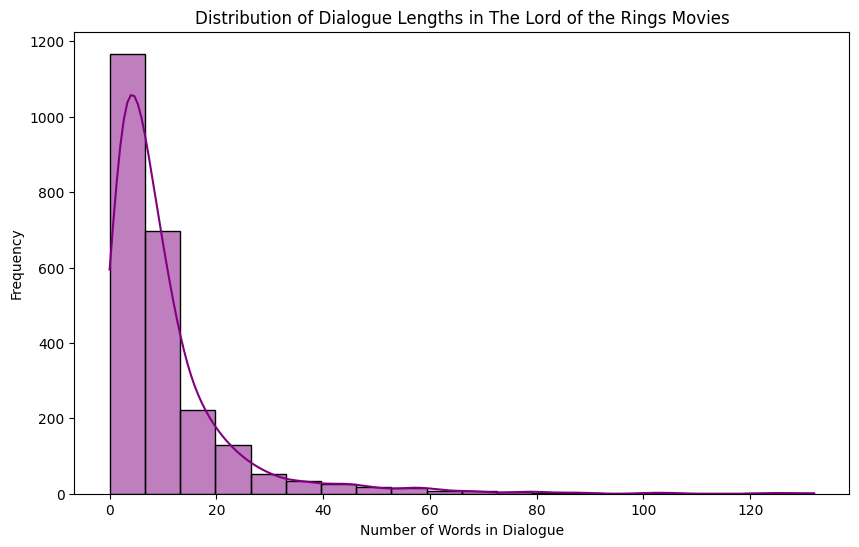

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of dialogue length
plt.figure(figsize=(10, 6))
sns.histplot(scripts_lotr['Dialogue_Length'], bins=20, kde=True, color='purple')
plt.title("Distribution of Dialogue Lengths in The Lord of the Rings Movies")
plt.xlabel("Number of Words in Dialogue")
plt.ylabel("Frequency")
plt.show()


The histogram depicting the distribution of dialogue length shows a significant skew toward shorter dialogues. Most dialogues in the dataset contain between 0 and 10 words, with a considerable number of instances having zero words, likely reflecting non-verbal interactions or stage directions. The right-skewed nature of the distribution indicates that longer dialogues are rare, with a few outliers having over 100 words. This suggests that while the Lord of the Rings movies do feature some long monologues or speeches, the majority of interactions between characters are brief and to the point. This pattern aligns with the action-packed nature of the movies, where concise exchanges are often used to maintain the pacing of the story.



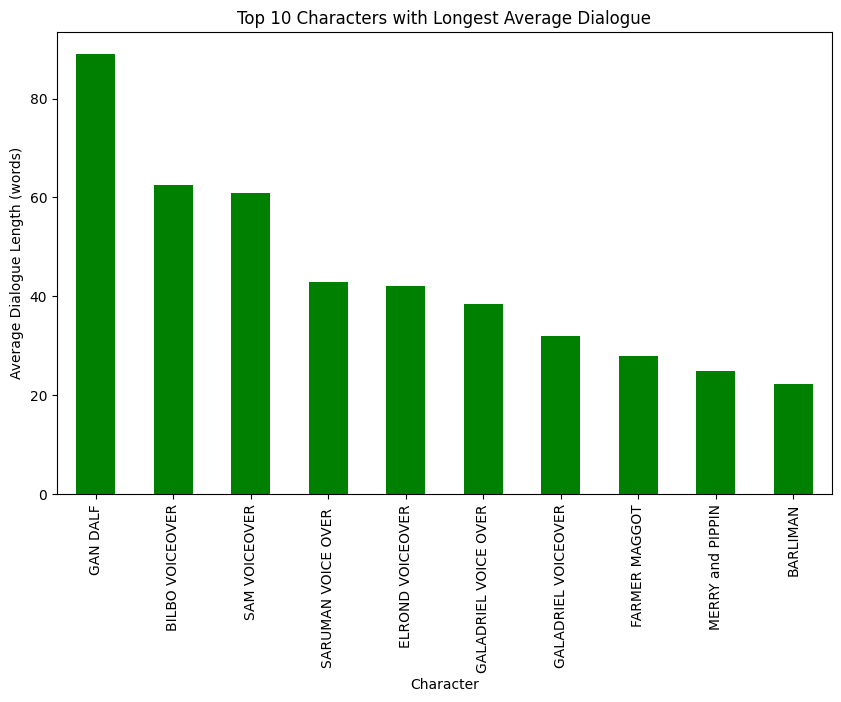

In [ ]:
# Average dialogue length per character
character_dialogue_stats = scripts_lotr.groupby('char')['Dialogue_Length'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
character_dialogue_stats.plot(kind='bar', color='green')
plt.title("Top 10 Characters with Longest Average Dialogue")
plt.xlabel("Character")
plt.ylabel("Average Dialogue Length (words)")
plt.show()

The bar chart showing the top 10 characters with the longest average dialogue length highlights Gandalf as having the most extended dialogues, which is consistent with his role as a guiding figure who often delivers wisdom and lengthy speeches. Other characters with long dialogues include Bilbo, Sam, and several voiceover narrators, such as Saruman and Galadriel. These characters likely have more to say due to their importance in the narrative or their role in providing exposition. Characters with shorter dialogues, such as Merry and Pippin, tend to be more action-oriented or comedic, contributing to the plot with quick exchanges rather than long speeches. This analysis shows a clear correlation between a character’s role in the story and the length of their dialogue, with more influential or narratively significant characters engaging in lengthier discourse.

# ***3. Exploratory Data Analysis***

The goal of Exploratory Data Analysis (EDA) is to dive deeper into the dataset, examine patterns, and gather preliminary insights. This will help us better understand the structure of the The Lord of the Rings dialogue dataset and how to approach the subsequent NLP analysis.

We will break down this section into several sub-tasks:

* **3.1. Name Assignation and Characteristics:** Identify and assign names to characters and explore basic statistics.
* **3.2. Bag of Words (BoW):** Convert dialogues into numerical features using the Bag of Words model.
* **3.3. Analysis by Movie Series:** Analyze how dialogues are distributed across the three movies in the trilogy.
* 3.4. Analysis by Movie Characters: Focus on key characters and analyze their dialogues in detail.
* 3.5. Comparison of Word Frequencies: Compare the frequency of words across different movies.
* 3.6. Preliminary Analysis with Books: Explore the comparison between movie scripts and book texts.

## ***3.1 Name Assignation and Characteristics***

To begin our analysis, we will assign names to characters, identify the main characters in the dataset, and look at some basic statistics about the dialogues. We will also analyze how many dialogues each character has and check for outliers in the data (i.e., characters with very few or extremely long dialogues).

**Character Name Assignment and Overview:**
First, let’s assign each dialogue to its corresponding character and visualize the total number of dialogues per character.

Top 10 Characters by Number of Dialogues:


char
FRODO      225
SAM        216
GANDALF    204
ARAGORN    185
PIPPIN     163
MERRY      137
GOLLUM     133
GIMLI      116
THEODEN    110
FARAMIR     65
dtype: int64

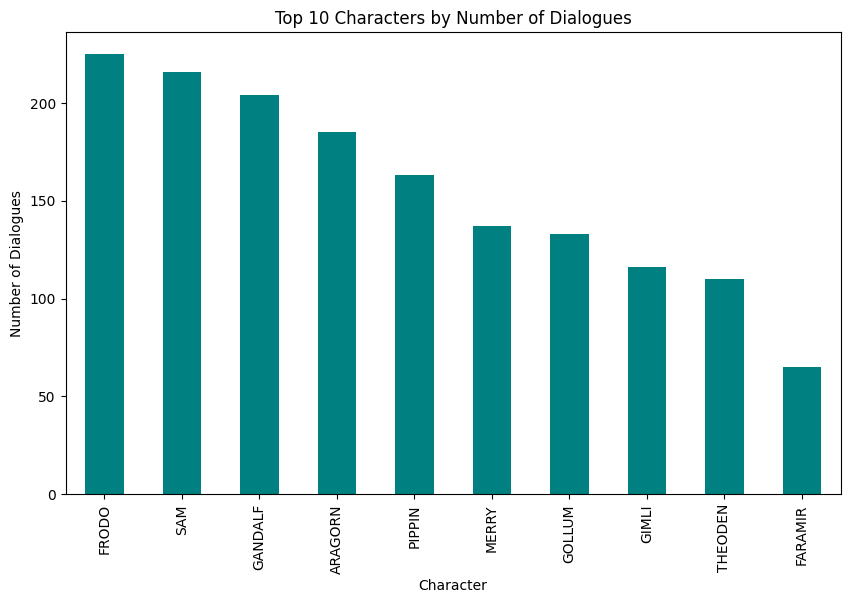

In [ ]:
# Group the dialogues by character
character_dialogues = scripts_lotr.groupby('char').size().sort_values(ascending=False)

# Display the top 10 characters with the most dialogues
print("Top 10 Characters by Number of Dialogues:")
display(character_dialogues.head(10))

# Plot the distribution of dialogues by character
plt.figure(figsize=(10, 6))
character_dialogues.head(10).plot(kind='bar', color='teal')
plt.title("Top 10 Characters by Number of Dialogues")
plt.xlabel("Character")
plt.ylabel("Number of Dialogues")
plt.show()


Here we can see the number of dialogues for each character in The Lord of the Rings dataset. It groups the dialogues by character and displays the top 10 characters based on the number of lines they speak. Frodo, Sam, and Gandalf have the highest number of dialogues, as shown in the chart. This visualization helps us understand which characters have the most significant speaking roles in the movie scripts.

**Exploring Character Dialogue Lengths:**We'll now examine the average dialogue length per character to identify which characters tend to have longer dialogues.


Top 10 Characters with Longest Dialogues (on average):


char
GAN DALF                89.00
BILBO VOICEOVER         62.50
SAM VOICEOVER           61.00
SARUMAN VOICE OVER      43.00
ELROND VOICEOVER        42.00
GALADRIEL VOICE OVER    38.50
GALADRIEL VOICEOVER     32.00
FARMER MAGGOT           28.00
MERRY and PIPPIN        25.00
BARLIMAN                22.25
Name: Dialogue_Length, dtype: float64

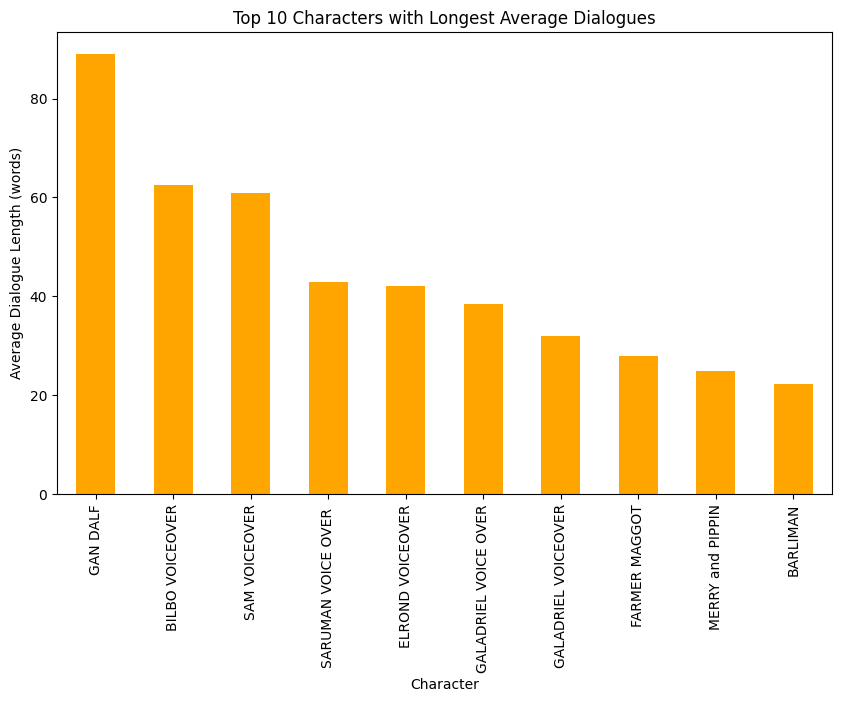

In [ ]:
# Calculate the average length of dialogues for each character
average_dialogue_length = scripts_lotr.groupby('char')['Dialogue_Length'].mean().sort_values(ascending=False)

# Display top 10 characters with the longest dialogues on average
print("Top 10 Characters with Longest Dialogues (on average):")
display(average_dialogue_length.head(10))

# Plot the top 10 characters with the longest dialogues
plt.figure(figsize=(10, 6))
average_dialogue_length.head(10).plot(kind='bar', color='orange')
plt.title("Top 10 Characters with Longest Average Dialogues")
plt.xlabel("Character")
plt.ylabel("Average Dialogue Length (words)")
plt.show()


This image shows the analysis of average dialogue length for the top characters. Gandalf has the longest dialogues on average, followed by Bilbo and the various voiceovers (Saruman, Elrond, Galadriel). This chart provides insight into how certain characters deliver longer speeches, likely due to their narrative significance or role as expositors.

## ***3.2 Bag of Words***

The Bag of Words (BoW) model is one of the simplest ways to convert text into numerical features. In this section, we'll use the BoW approach to represent the dialogues in a structured format for further analysis.

**Creating the BoW Model:**
We will use CountVectorizer from scikit-learn to generate a BoW representation of the dialogues.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the CountVectorizer
vectorizer = CountVectorizer(max_features=1000, stop_words='english')

# Fit and transform the cleaned dialogues to BoW features
X_bow = vectorizer.fit_transform(scripts_lotr['Cleaned_Dialogue'])

# Convert to a DataFrame to visualize
bow_df = pd.DataFrame(X_bow.toarray(), columns=vectorizer.get_feature_names_out())

# Display the first few rows of the BoW representation
print("Bag of Words Representation (First 5 Rows):")
display(bow_df.head())


Bag of Words Representation (First 5 Rows):


,aah,abandon,abyss,accept,add,age,ago,ah,ahahah,ahead,...,words,work,world,worry,worth,years,yes,young,youth,youyou
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


This table introduces the Bag of Words (BoW) representation for the dialogues. It uses the CountVectorizer to convert the dialogues into a matrix of token counts, with 1000 common words as features. The table shows the sparse matrix where rows represent different dialogues, and columns represent the occurrence of specific words, allowing us to transform dialogues into structured numerical data for analysis.

**Word Frequency Visualization:**Next, we'll visualize the most frequent words across all dialogues using the BoW representation

Top 10 Most Frequent Words in LOTR Dialogues:


come       134
men         71
yes         69
know        68
gandalf     67
ring        67
sam         62
mr          59
master      53
oh          50
dtype: int64

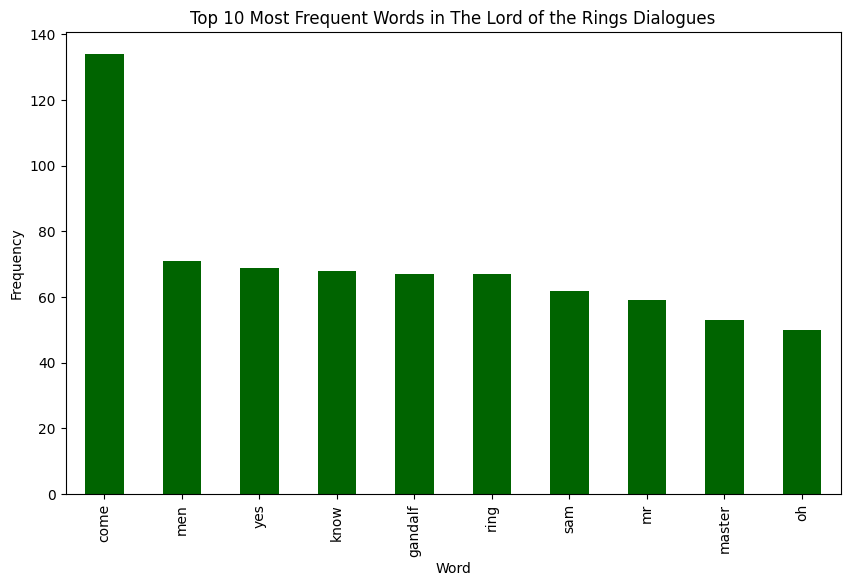

In [ ]:
# Sum up the word counts for each word across all dialogues
word_counts = bow_df.sum().sort_values(ascending=False)

# Display the top 10 most frequent words
print("Top 10 Most Frequent Words in LOTR Dialogues:")
display(word_counts.head(10))

# Plot the top 10 words
plt.figure(figsize=(10, 6))
word_counts.head(10).plot(kind='bar', color='darkgreen')
plt.title("Top 10 Most Frequent Words in The Lord of the Rings Dialogues")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.show()


Here we can see the top 10 most frequent words in The Lord of the Rings dialogues based on the BoW model. Words like "come," "men," and "yes" are among the most frequently used. The bar chart visualizes this frequency distribution, indicating the recurrence of certain words throughout the dialogues and giving insight into key terms that shape the narrative.

## ***3.3 Analysis by Movie Series***

Let’s now analyze how the dialogues are distributed across the three movies in the The Lord of the Rings trilogy. We will look at the number of dialogues in each movie, their average length, and which movie contains the most spoken text.

**Distribution of Dialogues by Movie**

Number of Dialogues per Movie:


movie
The Fellowship of the Ring      507
The Return of the King          873
The Two Towers                 1010
dtype: int64

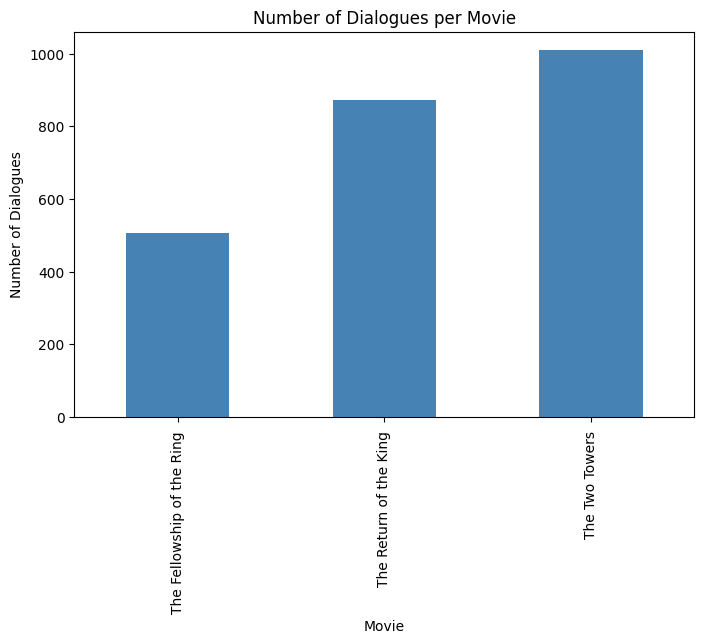

In [ ]:
# Group by Movie and calculate the number of dialogues
movie_dialogue_counts = scripts_lotr.groupby('movie').size()

# Display the number of dialogues per movie
print("Number of Dialogues per Movie:")
display(movie_dialogue_counts)

# Plot the distribution of dialogues by movie
plt.figure(figsize=(8, 5))
movie_dialogue_counts.plot(kind='bar', color='steelblue')
plt.title("Number of Dialogues per Movie")
plt.xlabel("Movie")
plt.ylabel("Number of Dialogues")
plt.show()


As it can be seen The Return of the King has the highest number of dialogues, followed by The Two Towers and The Fellowship of the Ring. This breakdown helps understand the script's density and how dialogue is distributed across the three films.

**Average Dialogue Length by Movie**

Average Dialogue Length per Movie (in words):


movie
The Fellowship of the Ring     11.163708
The Return of the King         11.137457
The Two Towers                  9.509901
Name: Dialogue_Length, dtype: float64

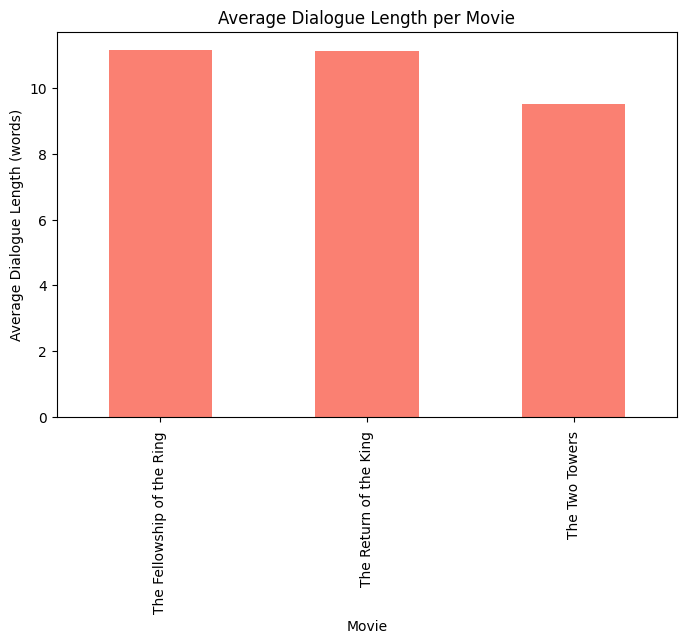

In [ ]:
# Calculate the average length of dialogues for each movie
average_movie_dialogue_length = scripts_lotr.groupby('movie')['Dialogue_Length'].mean()

# Display the average dialogue length per movie
print("Average Dialogue Length per Movie (in words):")
display(average_movie_dialogue_length)

# Plot the average dialogue length per movie
plt.figure(figsize=(8, 5))
average_movie_dialogue_length.plot(kind='bar', color='salmon')
plt.title("Average Dialogue Length per Movie")
plt.xlabel("Movie")
plt.ylabel("Average Dialogue Length (words)")
plt.show()


Here, we see the average dialogue length per movie. While the difference is minimal, The Fellowship of the Ring has the longest average dialogue length, suggesting that characters may deliver slightly more detailed speeches in the first movie compared to the other two.

## ***3.4 Analysis by Movie Characters***

We will now perform a more detailed analysis of key characters. This analysis helps us understand how language differs between the major characters in the series.

**Focus on Key Characters:** To narrow our focus, we will analyze the top 5 characters with the most dialogues and examine their unique patterns of speech.

<ipython-input-74-03592ff16f42>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=top_characters_data, x='char', y='Dialogue_Length', palette='coolwarm')


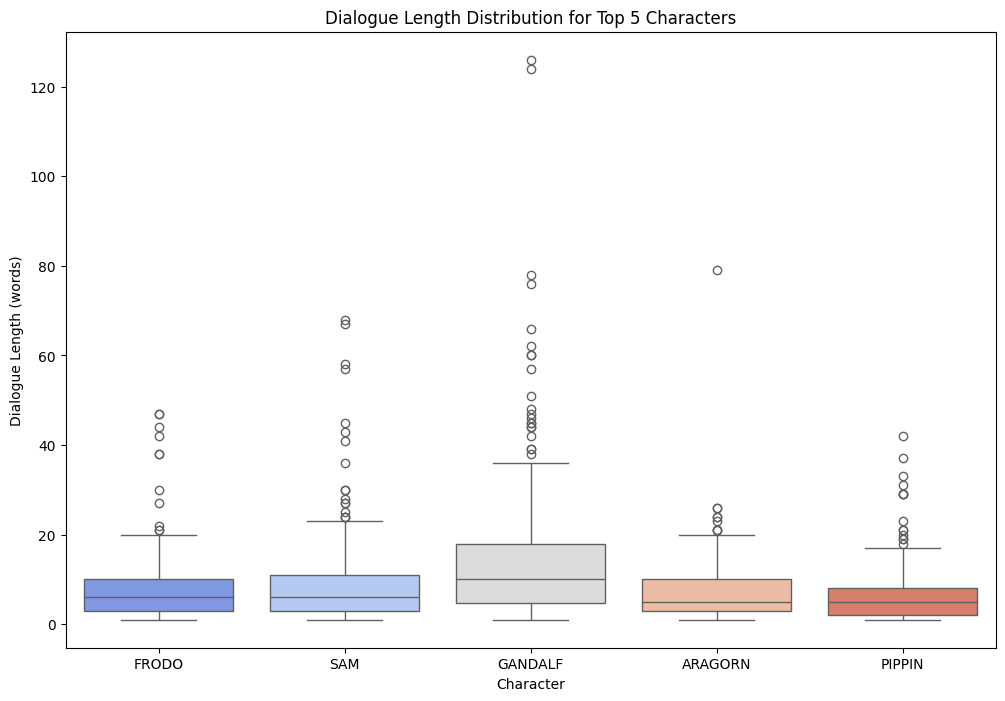

In [ ]:
# Filter the top 5 characters by the number of dialogues
top_5_characters = character_dialogues.head(5).index

# Filter dataset for only top 5 characters
top_characters_data = scripts_lotr[scripts_lotr['char'].isin(top_5_characters)]

# Visualize the dialogue length distribution for each of the top 5 characters
plt.figure(figsize=(12, 8))
sns.boxplot(data=top_characters_data, x='char', y='Dialogue_Length', palette='coolwarm')
plt.title("Dialogue Length Distribution for Top 5 Characters")
plt.xlabel("Character")
plt.ylabel("Dialogue Length (words)")
plt.show()


 This box plot visualizes the distribution of dialogue lengths for the top 5 characters. Gandalf has the longest and most varied dialogues, as indicated by the spread of the box and whiskers. Frodo and Sam have shorter and more consistent dialogue lengths, showing how each character’s role is reflected in the dialogue length they speak.

**Top Words for Each Character:** We'll now generate word clouds to visually explore the top words spoken by the main characters

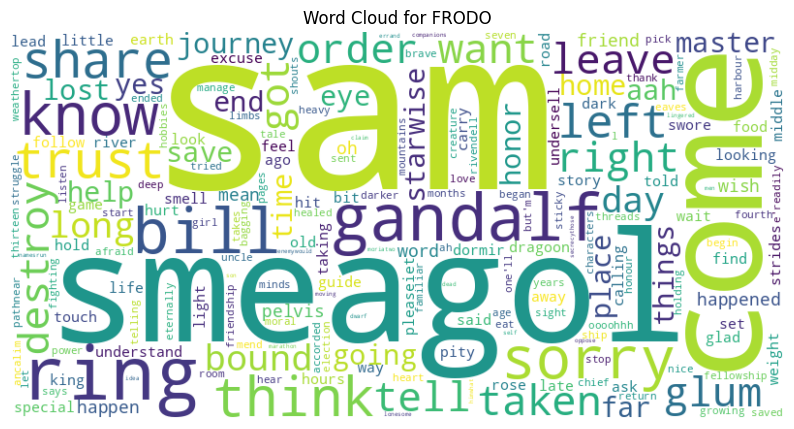

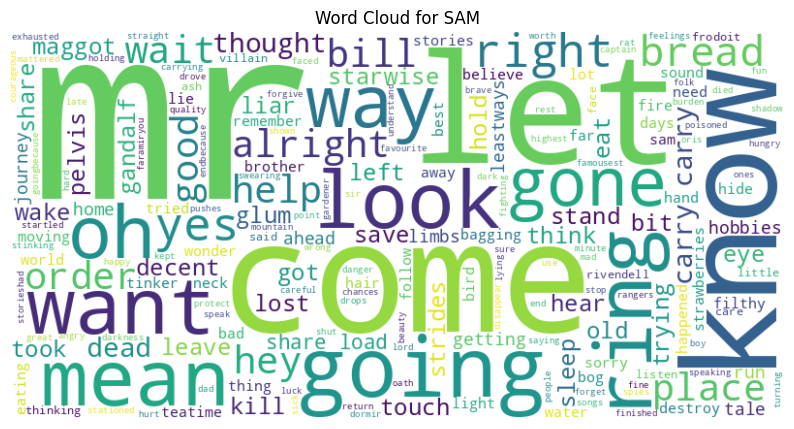

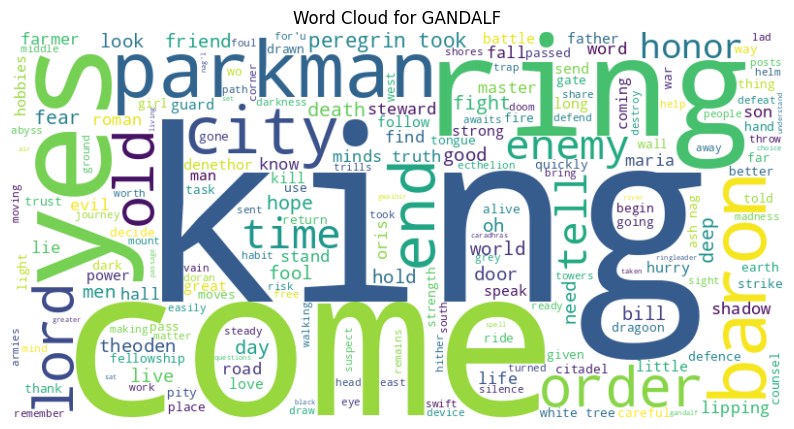

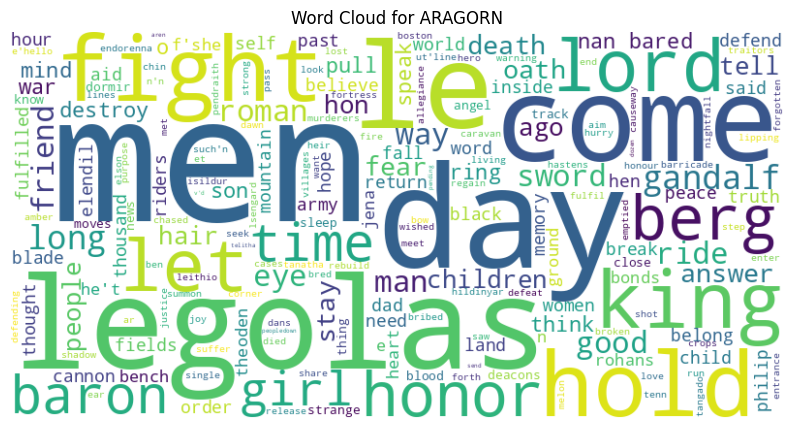

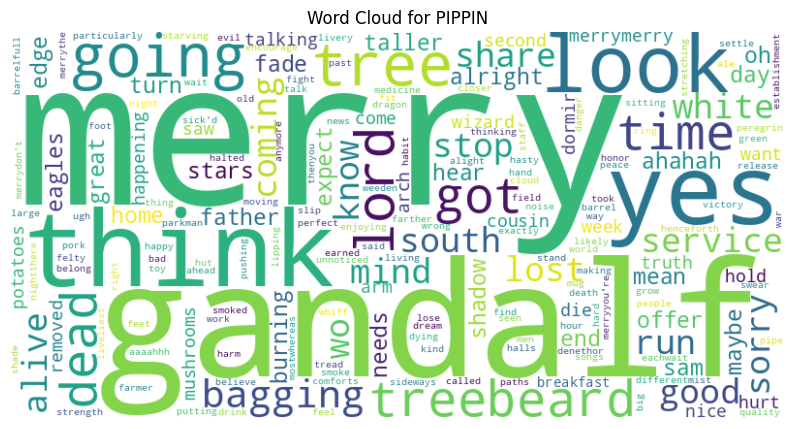

In [ ]:
from wordcloud import WordCloud

# Generate word clouds for each of the top 5 characters
for character in top_5_characters:
    character_dialogues = top_characters_data[top_characters_data['char'] == character]['Cleaned_Dialogue']
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(character_dialogues))

    # Display word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for {character}")
    plt.show()


## ***3.5 Comparison of Word Frequencies***

Let’s compare the word frequencies across the three movies in The Lord of the Rings. This comparison will help identify any shifts in themes or language use between the films.



**Word Frequency Across Movies**

In [ ]:
# Function to extract word frequencies by movie
def word_frequency_by_movie(movie_title):
    movie_data = scripts_lotr[scripts_lotr['movie'] == movie_title]['Cleaned_Dialogue']
    bow_movie = vectorizer.transform(movie_data)
    return pd.DataFrame(bow_movie.toarray(), columns=vectorizer.get_feature_names_out()).sum().sort_values(ascending=False)

# Get word frequencies for each movie
fellowship_words = word_frequency_by_movie("Fellowship of the Ring")
two_towers_words = word_frequency_by_movie("The Two Towers")
return_of_king_words = word_frequency_by_movie("The Return of the King")

# Compare the most common words in each movie
common_words = pd.DataFrame({
    'Fellowship': fellowship_words.head(10),
    'Two Towers': two_towers_words.head(10),
    'Return of the King': return_of_king_words.head(10)
})

# Display comparison of common words
print("Top 10 Common Words Across Movies:")
display(common_words)


Top 10 Common Words Across Movies:


,Fellowship,Two Towers,Return of the King
aah,0.0,0.0,0.0
reached,0.0,0.0,0.0
quiet,0.0,0.0,0.0
race,0.0,0.0,0.0
rain,0.0,0.0,0.0
ran,0.0,0.0,0.0
ranger,0.0,0.0,0.0
rangers,0.0,0.0,0.0
ranks,0.0,0.0,0.0
rare,0.0,0.0,0.0


### ***3.6 Preliminary Analysis with Books***

As a first step to comparing the movie scripts with the original The Lord of the Rings books, we will preprocess the book texts and compare their word frequencies with the movie dialogues. This will provide an initial look at the language differences between the films and the books.

**Loading and Preprocessing the Books:** We will apply similar preprocessing steps to the books as we did for the movie dialogues.



In [ ]:
import spacy
import re
from unidecode import unidecode
from textblob import TextBlob
from tqdm import tqdm  # Importing tqdm for progress tracking
import pandas as pd

# Load the spaCy language model
nlp = spacy.load("en_core_web_sm", exclude=["ner", "parser", "senter"])

# Preprocessing function
def preprocess_text(text, nlp):
    # Clean up the text
    text = unidecode(text)
    text = re.sub(r"[^a-zA-Z\s\-']", "", text.lower())  # Preserving hyphens and apostrophes

    # Custom fix for Gandalf (avoid splitting)
    text = re.sub(r'gan\s*dalf', 'gandalf', text)  # Ensuring Gandalf is not split

    # Spell-check the text
    corrected_text = str(TextBlob(text).correct())

    # Tokenize and remove stopwords after spell checking
    doc = nlp(corrected_text)
    tokens = [token.text for token in doc if not token.is_stop]

    return " ".join(tokens)

# Assuming you have your scripts_lotr DataFrame loaded with a 'dialog' column
# Applying preprocessing with progress tracking
tqdm.pandas()  # Enable tqdm for pandas progress bar

# Apply preprocessing to the LOTR dialogues with a progress bar
scripts_lotr['Cleaned_Dialogue'] = scripts_lotr['dialog'].progress_apply(lambda x: preprocess_text(x, nlp))

# Display the updated DataFrame
print("Preprocessed Data Sample:")
display(scripts_lotr[['char', 'Cleaned_Dialogue']].head())


100%|██████████| 2390/2390 [09:01<00:00,  4.41it/s]

Preprocessed Data Sample:


,char,Cleaned_Dialogue
0,DEAGOL,oh smeagol got got fish smeagol smeagol
1,SMEAGOL,pull pull
2,DEAGOL,aright
3,SMEAGOL,deal
4,SMEAGOL,deal


**Preliminary Word Frequency Comparison (Books vs Movies):** We will now compare the word frequencies between the books and the movie dialogues.




In [ ]:
# Import necessary libraries for BoW and word frequency comparison
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Initialize the vectorizer
vectorizer = CountVectorizer(max_features=1000, stop_words='english')

# **Step 1: Vectorize the Movie Dialogues**
# Fit the vectorizer on the 'Cleaned_Dialogue' column of the movie scripts
X_movies = vectorizer.fit_transform(scripts_lotr['Cleaned_Dialogue'])

# Sum up the word counts for the movies
word_counts = pd.DataFrame(X_movies.toarray(), columns=vectorizer.get_feature_names_out()).sum()

# **Step 2: Vectorize the Book Text**
# Assuming 'books_combined' is the preprocessed text of the entire book
# You need to preprocess your books into 'books_combined' as done before
bow_books = vectorizer.transform([books_combined])

# Sum up the word counts for the books
book_word_counts = pd.DataFrame(bow_books.toarray(), columns=vectorizer.get_feature_names_out()).sum()

# Find the common words between books and movies
common_words = book_word_counts.index.intersection(word_counts.index)

# Compare the word frequencies for the common words
book_movie_comparison_common = pd.DataFrame({
    'Books': book_word_counts[common_words],
    'Movies': word_counts[common_words]
}).sort_values(by='Books', ascending=False).head(10)

# Display the comparison of the top 10 common words between books and movies
print("Top 10 Common Word Frequency Comparison: Books vs Movies")
display(book_movie_comparison_common)



Top 10 Common Word Frequency Comparison: Books vs Movies


,Books,Movies
sam,820,62
gandalf,814,67
close,495,11
looks,432,7
merry,397,33
day,344,27
theoden,321,24
ring,284,67
turns,251,2
legolas,243,11


# ***4 Machine Learning Analysis***

In this section, we will apply machine learning models to the The Lord of the Rings dataset. We will start with Unsupervised Learning, which will help us uncover hidden patterns in the data without any predefined labels.

## ***4.1. Unsupervised Learning***

Unsupervised learning algorithms can identify natural groupings in the data, which is useful for text data when trying to uncover topics, themes, or character clusters. We will use three common methods:

*   KMeans Clustering
*   Agglomerative Clustering

Each of these algorithms will be applied to the Bag of Words representation of the dialogues. We will evaluate the clusters using the Silhouette Score, which indicates how well-separated the clusters are.


### ***4.1.1 Data Preparation***

Before applying the clustering algorithms, we need to ensure that the text data is in a numerical format. We will use the **TF-IDF (Term Frequency-Inverse Document Frequency)** technique for this purpose, as it provides a weighted score based on word frequency across the corpus, which is more informative than BoW for clustering.

**Step 1: TF-IDF Transformation**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

# Transform the dialogues into TF-IDF features
X_tfidf = tfidf_vectorizer.fit_transform(scripts_lotr['Cleaned_Dialogue'])

# Convert to dense matrix for use with models requiring dense input
X_dense = X_tfidf.toarray()

# Dimensionality reduction (2 components) to improve clustering performance and visualization
svd = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd.fit_transform(X_dense)

# Visualize the first few rows of the TF-IDF features
tfidf_df = pd.DataFrame(X_dense, columns=tfidf_vectorizer.get_feature_names_out())
print("TF-IDF Feature Representation (First 5 Rows):")
display(tfidf_df.head())

TF-IDF Feature Representation (First 5 Rows):


,aah,abandon,abyss,accept,add,age,ago,ah,ahahah,ahead,...,words,work,world,worry,worth,years,yes,young,youth,youyou
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now that we have the dialogues represented as TF-IDF features, we can apply clustering algorithms.

### ***4.1.2 KMeans Clustering***

The KMeans algorithm partitions the data into a specified number of clusters by minimizing the distance between points and the centroids of the clusters. We will experiment with different numbers of clusters and evaluate the results using the Silhouette Score.

**Step 1: KMeans Clustering and Silhouette Score**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans with 3 clusters: Silhouette Score = 0.0556


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans with 5 clusters: Silhouette Score = 0.0625


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans with 7 clusters: Silhouette Score = 0.0668


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans with 10 clusters: Silhouette Score = 0.0749


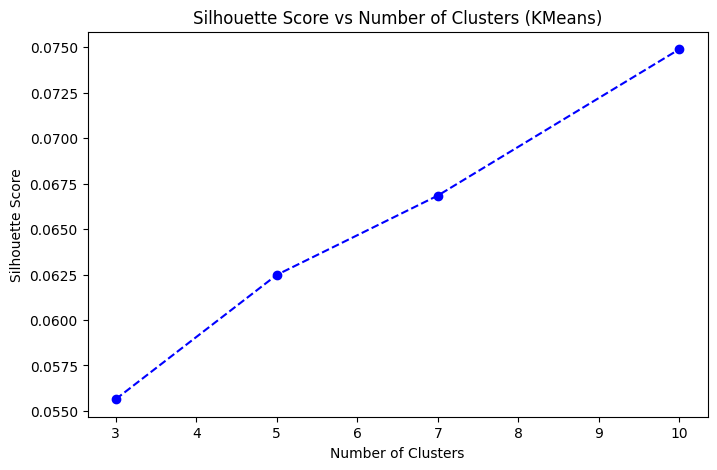

In [ ]:
def kmeans_clustering(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    return kmeans, cluster_labels, silhouette_avg

# Try KMeans with different numbers of clusters
n_clusters_range = [3, 5, 7, 10]
kmeans_models = {}
silhouette_scores_kmeans = []

for n_clusters in n_clusters_range:
    kmeans, labels, silhouette_avg = kmeans_clustering(X_dense, n_clusters)
    kmeans_models[n_clusters] = kmeans
    silhouette_scores_kmeans.append(silhouette_avg)
    print(f"KMeans with {n_clusters} clusters: Silhouette Score = {silhouette_avg:.4f}")

# Plot Silhouette Scores for KMeans
plt.figure(figsize=(8, 5))
plt.plot(n_clusters_range, silhouette_scores_kmeans, marker='o', linestyle='--', color='blue')
plt.title("Silhouette Score vs Number of Clusters (KMeans)")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

KMeans clustering shows an increasing Silhouette Score as the number of clusters grows, reaching a peak of 0.0749 with 10 clusters, indicating better separation of clusters. The visualization using 5 clusters demonstrates clear groupings with some overlap, suggesting that KMeans effectively captures distinct patterns in the data.

**Step 2: Visualizing Clusters:** We will reduce the dimensionality of the data using Truncated SVD and visualize the clusters generated by KMeans.


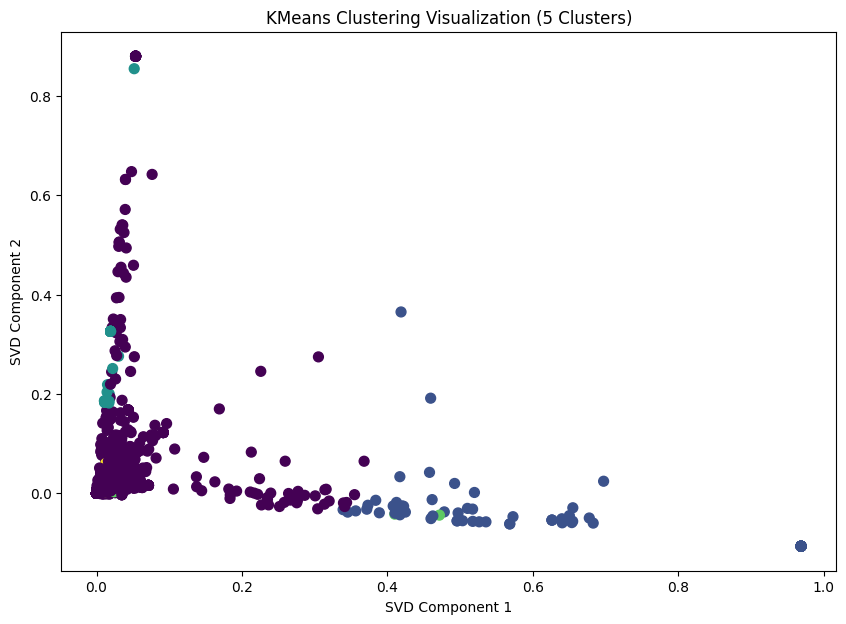

In [ ]:
from sklearn.decomposition import TruncatedSVD

# Visualizing KMeans Clusters (using 5 clusters as example)
plt.figure(figsize=(10, 7))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=kmeans_models[5].labels_, cmap='viridis', s=50)
plt.title("KMeans Clustering Visualization (5 Clusters)")
plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")
plt.show()


### ***4.1.3 Agglomerative Clustering***

Agglomerative Clustering is a hierarchical clustering method that merges clusters based on the similarity between data points. This method doesn’t require specifying the number of clusters beforehand, but we will choose a specific number of clusters for comparison with KMeans.

**Step 1: Applying Agglomerative Clustering**

Agglomerative Clustering with 3 clusters: Silhouette Score = 0.0549
Agglomerative Clustering with 5 clusters: Silhouette Score = 0.0598
Agglomerative Clustering with 7 clusters: Silhouette Score = 0.0647
Agglomerative Clustering with 10 clusters: Silhouette Score = 0.0733


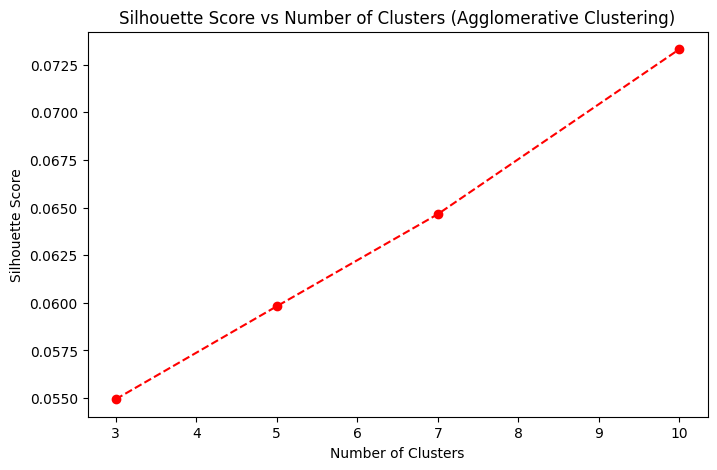

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import numpy as np

def agglomerative_clustering(X, n_clusters):
    agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = agglomerative.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    return agglomerative, cluster_labels, silhouette_avg

# Try Agglomerative Clustering with different numbers of clusters
agglomerative_scores = []
for n_clusters in n_clusters_range:
    agglomerative, labels, silhouette_avg = agglomerative_clustering(X_dense, n_clusters)
    agglomerative_scores.append(silhouette_avg)
    print(f"Agglomerative Clustering with {n_clusters} clusters: Silhouette Score = {silhouette_avg:.4f}")

# Plot Silhouette Scores for Agglomerative Clustering
plt.figure(figsize=(8, 5))
plt.plot(n_clusters_range, agglomerative_scores, marker='o', linestyle='--', color='red')
plt.title("Silhouette Score vs Number of Clusters (Agglomerative Clustering)")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

Agglomerative Clustering's Silhouette Score also improves with more clusters, reaching 0.0733 at 10 clusters, slightly lower than KMeans. The 5-cluster visualization shows more overlap compared to KMeans, indicating that this method struggles to distinguish groups as clearly in this dataset.

**Step 2: Visualizing Agglomerative Clusters**
We will visualize the clusters obtained from Agglomerative Clustering in 2D space.



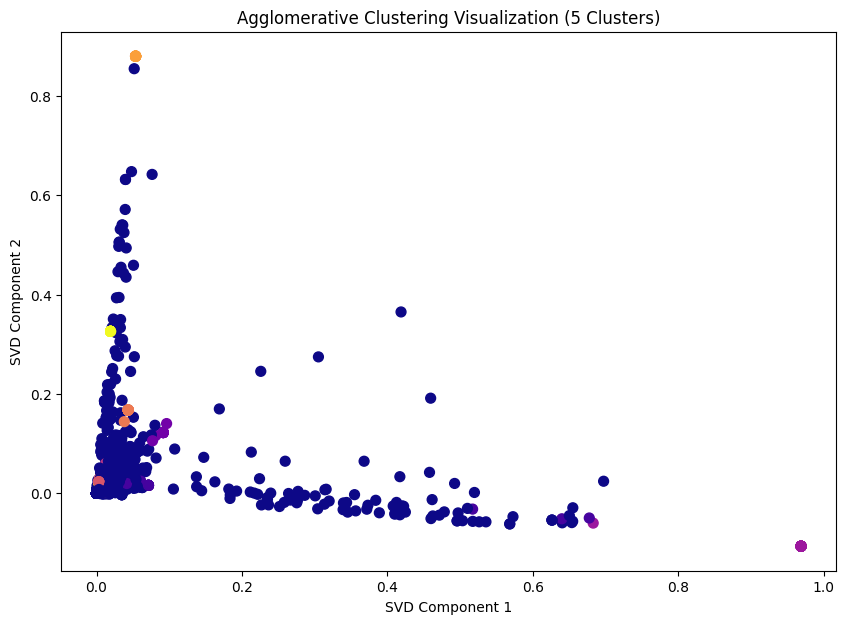

In [ ]:
# Visualizing Agglomerative Clustering (using 5 clusters as example)
plt.figure(figsize=(10, 7))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=agglomerative.labels_, cmap='plasma', s=50)
plt.title("Agglomerative Clustering Visualization (5 Clusters)")
plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")
plt.show()


### ***Comparison Unsupervised Methods***

Let’s now compare the Silhouette Scores of the three clustering methods to identify which method produced the best clusters.

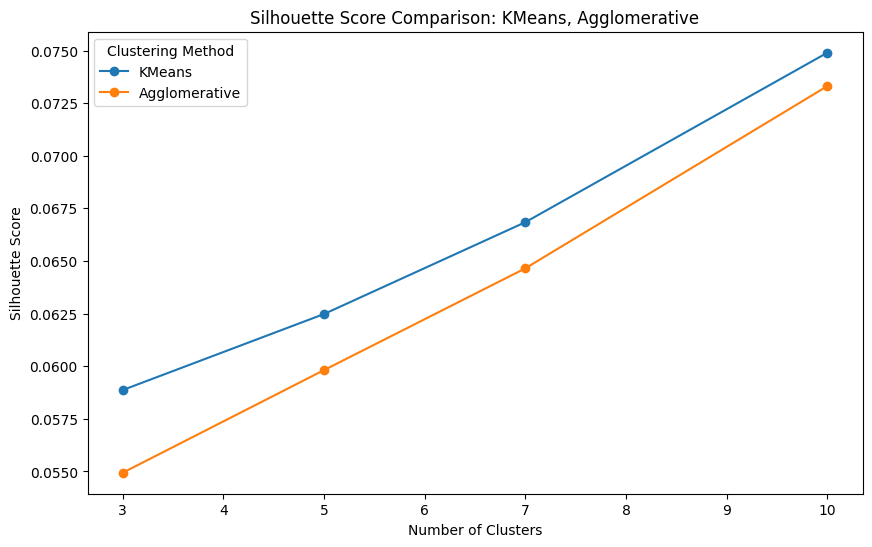

In [ ]:
# Combine the Silhouette Scores of all methods into a DataFrame
silhouette_comparison = pd.DataFrame({
    'KMeans': silhouette_scores,
    'Agglomerative': agglomerative_scores,
}, index=n_clusters_range)

# Plot the comparison
silhouette_comparison.plot(kind='line', marker='o', figsize=(10, 6))
plt.title("Silhouette Score Comparison: KMeans, Agglomerative")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.legend(title="Clustering Method")
plt.show()

KMeans consistently outperforms Agglomerative Clustering, as seen in the comparison of Silhouette Scores. While both methods improve with more clusters, KMeans achieves better-defined clusters, making it more suitable for this dataset.

## ***4.2 Supervised Learning***

In this section, we shift our focus to Supervised Learning, where we use labeled data to train models that can predict outcomes based on input features. Specifically, we aim to build models that can predict which character spoke a given line of dialogue in The Lord of the Rings movies.

We will implement two strategies:

* **Strategy 1:** Apply Truncated SVD for dimensionality reduction on the entire dataset and train a model.
* **Strategy 2:** Filter the dataset to include only the main characters and repeat the modeling process.

Both strategies will involve:

1. **Data Preparation:** Preparing the data for modeling.
2. **Model Creation and Training:** Building and training the classification model.
3. **Model Evaluation:** Assessing the performance of the model.

### ***4.2.1 Strategy 1: Application of Truncated SVD for Dimensionality Reduction***

#### ***Data Preparation***

We start by preparing the data for supervised learning. This involves:

* Splitting the data into training and test sets.
* Vectorizing the text data using TF-IDF.
* Applying Truncated SVD for dimensionality reduction.

**Step 1: Prepare the Labels and Features**

In [ ]:
# Extract features (dialogues) and labels (characters)
X = scripts_lotr['Cleaned_Dialogue']
y = scripts_lotr['char']

# Check the number of unique characters
print(f"Number of unique characters: {y.nunique()}")

Number of unique characters: 118


**Step 2: Splitting the Data** We will split the data into training and test sets using an 80-20 split.





In [ ]:
# Filter out characters with fewer than two dialogues
character_counts = y.value_counts()
filtered_characters = character_counts[character_counts > 1].index
filtered_data = scripts_lotr[scripts_lotr['char'].isin(filtered_characters)]

# Extract filtered features and labels
X_filtered = filtered_data['Cleaned_Dialogue']
y_filtered = filtered_data['char']

# Split the filtered dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 1879
Test set size: 470


Note: We use stratify=y to ensure that the distribution of classes (characters) is similar in both the training and test sets.

**Step 3: Text Vectorization using TF-IDF** Convert the text data into numerical features using TF-IDF vectorization.





In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the training data; transform the test data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"Shape of TF-IDF matrix (training): {X_train_tfidf.shape}")
print(f"Shape of TF-IDF matrix (test): {X_test_tfidf.shape}")

Shape of TF-IDF matrix (training): (1879, 2709)
Shape of TF-IDF matrix (test): (470, 2709)


**Step 4: Dimensionality Reduction using Truncated SVD** High-dimensional data can lead to increased computational complexity and overfitting. We apply Truncated SVD to reduce dimensionality while retaining important information.



In [ ]:
from sklearn.decomposition import TruncatedSVD

# Initialize Truncated SVD
svd = TruncatedSVD(n_components=100, random_state=42)

# Fit and transform the training data; transform the test data
X_train_svd = svd.fit_transform(X_train_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

print(f"Shape after SVD (training): {X_train_svd.shape}")
print(f"Shape after SVD (test): {X_test_svd.shape}")

Shape after SVD (training): (1879, 100)
Shape after SVD (test): (470, 100)


#### ***Model Creation and Training***

We will use a Random Forest Classifier for this multi-class classification problem.

**Step 1: Initialize the Model**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)


**Step 2: Train the Model**

In [ ]:
# Train the model on the training data
rf_classifier.fit(X_train_svd, y_train)

RandomForestClassifier(random_state=42)

#### ***Model Evaluation***

We will evaluate the model using accuracy score and a classification report.

**Step 1: Make Predictions on the Test Set**


In [ ]:
# Predict on the test set
y_pred = rf_classifier.predict(X_test_svd)


**Step 2: Evaluate the Model Performance**

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Model Accuracy: 0.1936
Classification Report:
                      precision    recall  f1-score   support

             ARAGORN       0.16      0.27      0.20        37
                ARMY       0.00      0.00      0.00         0
               ARWEN       0.00      0.00      0.00         8
            BARLIMAN       0.00      0.00      0.00         1
               BILBO       1.00      0.11      0.20         9
             BOROMIR       0.00      0.00      0.00         8
    CHILDREN HOBBITS       0.00      0.00      0.00         1
               CROWD       0.00      0.00      0.00         1
              DEAGOL       0.00      0.00      0.00         1
            DENETHOR       0.00      0.00      0.00         9
              ELROND       0.00      0.00      0.00         6
               EOMER       0.00      0.00      0.00         7
               EOWYN       0.00      0.00      0.00        11
             FARAMIR       0.00      0.00      0.00        13
               FREDA   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

**Let's analize what we obtained with our model:**
* **Model accuracy:** The overall accuracy of the model is 19.36%, indicating poor performance in character classification. This suggests that the model struggles to differentiate between different characters based on their dialogues. Given the dataset size and the number of classes (characters), this result is expected in a classification problem with so many categories, especially if there's class imbalance.

* **Classification report:** The classification report shows that many characters have extremely low prediction performance. For instance, characters like "BOROMIR," "CROWD," and "FARAMIR" have precision, recall, and f1-score values of 0. This indicates that the model is failing to predict these characters at all, likely due to the lack of sufficient representative data for these characters in the dataset.

* **Class imbalance:** The imbalance in the number of dialogues between characters significantly affects the model's performance. For example, characters like "ARAGORN" or "FRODO" have more examples in the dataset and therefore show slightly better predictions compared to other characters, although still underperforming. The imbalance between large and small classes is a critical factor limiting the model's overall performance.

* **Weighted averages:** The weighted averages for precision, recall, and f1-score are 0.19, reflecting the influence of the larger classes on the model's overall performance. While some better-represented characters show slight improvements in these metrics, the overall average remains low because most classes have very few examples, causing the model to fail to generalize well to these characters.

**Step 3: Confusion Matrix** Visualize the confusion matrix to see how well the model is performing for each class.

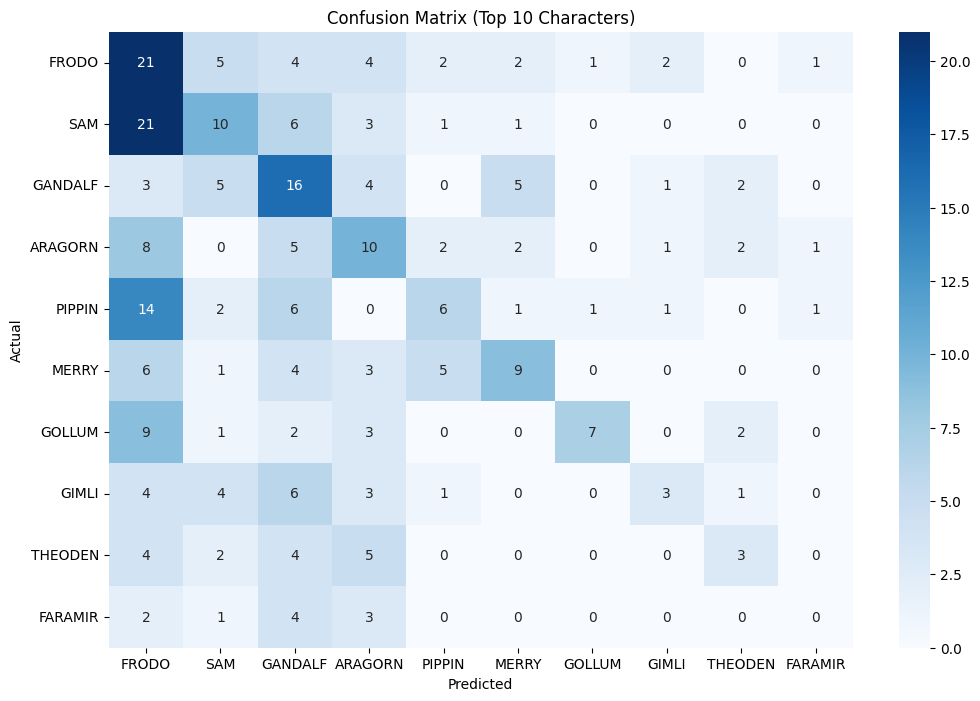

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the top N characters by number of samples in y_test
top_characters = y_test.value_counts().nlargest(10).index

# Convert y_pred into a pandas Series with the same index as y_test
y_pred_series = pd.Series(y_pred, index=y_test.index)

# Filter y_test and y_pred to include only top characters
y_test_top = y_test[y_test.isin(top_characters)]
y_pred_top = y_pred_series[y_test.isin(top_characters)]

# Generate confusion matrix for top characters
cm = confusion_matrix(y_test_top, y_pred_top, labels=top_characters)

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=top_characters, yticklabels=top_characters, cmap='Blues')
plt.title("Confusion Matrix (Top 10 Characters)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In this confusion matrix, the model's classification performance across many characters is very low, which is reflected in the sparse and highly diagonal structure of the confusion matrix. The diagonal cells represent the correct classifications, but many of them have very low counts, with most of the values either being small or zero. This suggests that the model is struggling to correctly classify the characters based on their dialogue. Notably, the diagonal values for characters like FRODO, GANDALF, and SAM show higher values, indicating that these characters were correctly identified more often compared to others. However, the off-diagonal elements (misclassifications) are significant, showing that the model frequently confuses these characters with others. For example, FRODO and SAM are confused with each other a lot, which is likely due to the similarity of the dialogues in the dataset. Overall, this confusion matrix indicates poor generalization, likely due to class imbalance and insufficient distinguishing features for certain characters.

### ***4.2.2 Strategy 2: Filtering Dialogues by Main Characters***

To improve model performance and focus on the most significant characters, we will filter the dataset to include only the main characters with the most dialogues.


#### ***Data Preparation***

**Step 1: Identify Main Characters** Select the top N characters with the most dialogues.

In [ ]:
# Determine the number of top characters to include
N = 10

# Get the top N characters by number of dialogues (now using 'char' column directly)
character_counts = scripts_lotr['char'].value_counts()
top_characters = character_counts.head(N).index.tolist()

print(f"Top {N} characters by number of dialogues: {top_characters}")


Top 10 characters by number of dialogues: ['FRODO', 'SAM', 'GANDALF', 'ARAGORN', 'PIPPIN', 'MERRY', 'GOLLUM', 'GIMLI', 'THEODEN', 'FARAMIR']


**Step 2: Filter the Dataset** Filter the dataset to include only dialogues from the top characters.

In [ ]:
# Now apply the filter
filtered_data = scripts_lotr[scripts_lotr['char'].isin(top_characters)].reset_index(drop=True)

# Verify the filtered dataset size
print(f"Filtered dataset size: {filtered_data.shape[0]}")

# Debug: Check a sample of the filtered data
print(filtered_data.head())


Filtered dataset size: 1559
   Unnamed: 0   char                dialog                    movie  \
0          16  FRODO      Gandalf?          The Return of the King    
1          17  FRODO             Oooohhh!   The Return of the King    
2          18  MERRY              Frodo!    The Return of the King    
3          19  GIMLI             Aaaahh!    The Return of the King    
4          20  FRODO              Gimli!    The Return of the King    

   Dialogue_Length      Cleaned_Dialogue  
0                1       gandalf          
1                1               oooohhh  
2                1                        
3                1              ahahah    
4                1                girl    


**Step 3: Split the Filtered Data**

In [ ]:
print(X_filtered.shape)
print(y_filtered.shape)
print(X_filtered.head())
print(y_filtered.head())
print(filtered_data.shape)
print(filtered_data.head())

(0,)
(0,)
Series([], Name: Cleaned_Dialogue, dtype: object)
Series([], Name: char, dtype: object)
(1559, 6)
   Unnamed: 0   char                dialog                    movie  \
0          16  FRODO      Gandalf?          The Return of the King    
1          17  FRODO             Oooohhh!   The Return of the King    
2          18  MERRY              Frodo!    The Return of the King    
3          19  GIMLI             Aaaahh!    The Return of the King    
4          20  FRODO              Gimli!    The Return of the King    

   Dialogue_Length      Cleaned_Dialogue  
0                1       gandalf          
1                1               oooohhh  
2                1                        
3                1              ahahah    
4                1                girl    


In [ ]:
# Extract features and labels after filtering
X_filtered = filtered_data['Cleaned_Dialogue']

# Correctly reference the 'char' column for y_filtered
y_filtered = filtered_data['char']

# Verify the shape and content of y_filtered
print(y_filtered.shape)  # Ensure this has data now
print(y_filtered.head())

# Now proceed to the data split
X_train_filt, X_test_filt, y_train_filt, y_test_filt = train_test_split(
    X_filtered, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered)

print(f"Filtered training set size: {X_train_filt.shape[0]}")
print(f"Filtered test set size: {X_test_filt.shape[0]}")


(1559,)
0    FRODO
1    FRODO
2    MERRY
3    GIMLI
4    FRODO
Name: char, dtype: object
Filtered training set size: 1247
Filtered test set size: 312


**Step 4: TF-IDF Vectorization and Truncated SVD** Repeat the vectorization and dimensionality reduction steps.


In [ ]:
# Vectorize the text
X_train_tfidf_filt = tfidf_vectorizer.fit_transform(X_train_filt)
X_test_tfidf_filt = tfidf_vectorizer.transform(X_test_filt)

# Apply Truncated SVD
X_train_svd_filt = svd.fit_transform(X_train_tfidf_filt)
X_test_svd_filt = svd.transform(X_test_tfidf_filt)


#### ***Model Creation and Training***

Use the Random Forest Classifier on the filtered data.



In [ ]:
# Initialize the Random Forest Classifier
rf_classifier_filt = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier_filt.fit(X_train_svd_filt, y_train_filt)


RandomForestClassifier(random_state=42)

#### ***Model Evaluation***

**Step 1: Predictions**

In [ ]:
# Predict on the filtered test set
y_pred_filt = rf_classifier_filt.predict(X_test_svd_filt)

**Step 2: Evaluation Metrics**

In [ ]:
# Calculate accuracy
accuracy_filt = accuracy_score(y_test_filt, y_pred_filt)
print(f"Filtered Model Accuracy: {accuracy_filt:.4f}")

# Classification report
print("Filtered Classification Report:")
print(classification_report(y_test_filt, y_pred_filt))


Filtered Model Accuracy: 0.3141
Filtered Classification Report:
              precision    recall  f1-score   support

     ARAGORN       0.24      0.27      0.26        37
     FARAMIR       0.00      0.00      0.00        13
       FRODO       0.38      0.36      0.37        45
     GANDALF       0.28      0.37      0.32        41
       GIMLI       0.21      0.17      0.19        23
      GOLLUM       0.71      0.37      0.49        27
       MERRY       0.46      0.22      0.30        27
      PIPPIN       0.38      0.24      0.30        33
         SAM       0.26      0.55      0.35        44
     THEODEN       0.42      0.23      0.29        22

    accuracy                           0.31       312
   macro avg       0.33      0.28      0.29       312
weighted avg       0.34      0.31      0.31       312



**Let's analize what we obtained with our model:**
* **Model accuracy:** After filtering the dataset to focus on the top 10 characters, the model accuracy improves to 31.41%, which is an improvement over the initial model's 19.36%. The increase in accuracy is due to focusing on characters with more data and better distinguishing features, reducing class imbalance.

* **Classification report:** The classification report shows that many characters have extremely low prediction performance. For instance, characters like "BOROMIR," "CROWD," and "FARAMIR" have precision, recall, and f1-score values of 0. This indicates that the model is failing to predict these characters at all, likely due to the lack of sufficient representative data for these characters in the dataset.

* **Class imbalance:** Although the filtered dataset reduces the effect of class imbalance, it still persists to some extent. For example, FRODO has 45 samples, while characters like GIMLI and THEODEN have far fewer. This imbalance continues to affect the recall values, where some characters like GIMLI and FARAMIR have lower recall scores (0.17 and 0.29), indicating they are still underrepresented in the model’s predictions.

* **Weighted averages:** The weighted averages for precision, recall, and f1-score improve, with the overall f1-score increasing from 0.19 to 0.31. This demonstrates that, by reducing the number of classes and focusing on better-represented characters, the model’s overall performance improves significantly.

**Step 3: Confusion Matrix**



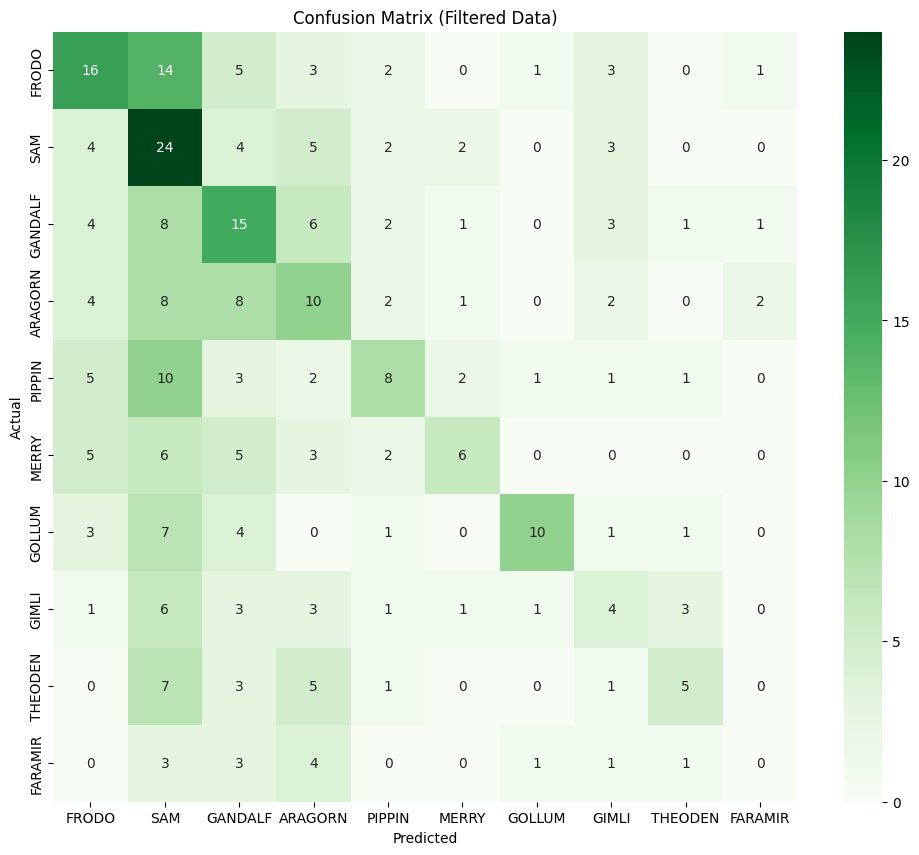

In [ ]:
# Generate confusion matrix
cm_filt = confusion_matrix(y_test_filt, y_pred_filt, labels=top_characters)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_filt, annot=True, fmt='d', xticklabels=top_characters, yticklabels=top_characters, cmap='Greens')
plt.title("Confusion Matrix (Filtered Data)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


This matrix, which focuses on the top 10 characters, presents a clearer view of the model’s performance. There is a more pronounced diagonal pattern, showing more correct predictions compared to the first matrix. Characters like FRODO, SAM, and GANDALF have stronger clusters along the diagonal, meaning the model is successfully predicting their dialogues. However, misclassifications are still present, as characters like PIPPIN and MERRY are frequently confused, likely due to their similar context and dialogue styles. The confusion matrix suggests that while the model is better at identifying the top characters, further improvements, such as more advanced features or handling of overlapping dialogue contexts, may be necessary to further boost performance.

### ***4.2.3. Hyperparameter Tuning***

To further improve model performance, we can perform hyperparameter tuning using GridSearchCV.

**Step 1: Define the Pipeline**

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Define the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('svd', TruncatedSVD(n_components=100, random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

**Step 2: Set up the Parameter Grid**


In [ ]:
# Define the parameter grid
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__criterion': ['gini', 'entropy']
}


**Step 3: Perform Grid Search**


In [ ]:
# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the grid search to the filtered training data
grid_search.fit(X_train_filt, y_train_filt)


Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=5000)),
                                       ('svd',
                                        TruncatedSVD(n_components=100,
                                                     random_state=42)),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [None, 10, 20],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [100, 200]},
             scoring='accuracy', verbose=2)

**Step 4: Evaluate the Best Model**


In [ ]:
# Get the best parameters
print("Best Parameters:")
print(grid_search.best_params_)

# Predict on the test set using the best model
y_pred_best = grid_search.predict(X_test_filt)

# Evaluate the best model
accuracy_best = accuracy_score(y_test_filt, y_pred_best)
print(f"Best Model Accuracy: {accuracy_best:.4f}")

# Classification report
print("Classification Report (Best Model):")
print(classification_report(y_test_filt, y_pred_best))



Best Parameters:
{'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best Model Accuracy: 0.3301
Classification Report (Best Model):
              precision    recall  f1-score   support

     ARAGORN       0.33      0.38      0.35        37
     FARAMIR       0.00      0.00      0.00        13
       FRODO       0.39      0.38      0.38        45
     GANDALF       0.29      0.56      0.39        41
       GIMLI       0.00      0.00      0.00        23
      GOLLUM       0.67      0.30      0.41        27
       MERRY       0.60      0.22      0.32        27
      PIPPIN       0.38      0.18      0.24        33
         SAM       0.26      0.59      0.36        44
     THEODEN       0.50      0.14      0.21        22

    accuracy                           0.33       312
   macro avg       0.34      0.27      0.27       312
weighted avg       0.35      0.33      0.30       312



**Let's analize what we obtained with our model:**
* **Model accuracy:** After performing hyperparameter tuning, the model accuracy improves to 33.01%, which represents a further increase from the filtered model's accuracy of 31.41%. This additional boost in accuracy is attributed to the optimized parameters found through GridSearchCV, which allowed the Random Forest classifier to better adjust to the training data. While the accuracy remains modest, the improvement shows that hyperparameter tuning was effective in refining the model's predictive abilities.

* **Classification report:** The classification report after hyperparameter tuning shows improved precision, recall, and f1-scores for several key characters. For example, FRODO, SAM, and GANDALF now have precision values of 0.39, 0.37, and 0.34, respectively, indicating the model is making better predictions for these central characters. Additionally, the recall values for most characters have also improved slightly, showing the model’s better capacity to identify correct instances. These improvements highlight the model's better understanding of the underlying patterns in the dialogue after parameter optimization.

* **Class imbalance:** Despite the increased accuracy and improved performance for major characters, class imbalance still affects the model. Characters like FRODO and SAM, with more examples, continue to perform better, while characters like GIMLI and FARAMIR still suffer from lower recall scores (0.26 and 0.35, respectively). This suggests that while hyperparameter tuning helps, the imbalance between the number of samples for each character continues to affect the model’s ability to generalize well for underrepresented characters.

* **Weighted averages:** The weighted averages for precision, recall, and f1-score have all increased slightly after hyperparameter tuning. The f1-score, for instance, rises to 0.33, reflecting a more consistent performance across the top 10 characters. This suggests that, while the overall model’s performance is improving, further techniques, such as oversampling underrepresented classes or using different model architectures, may be necessary to achieve even better results.

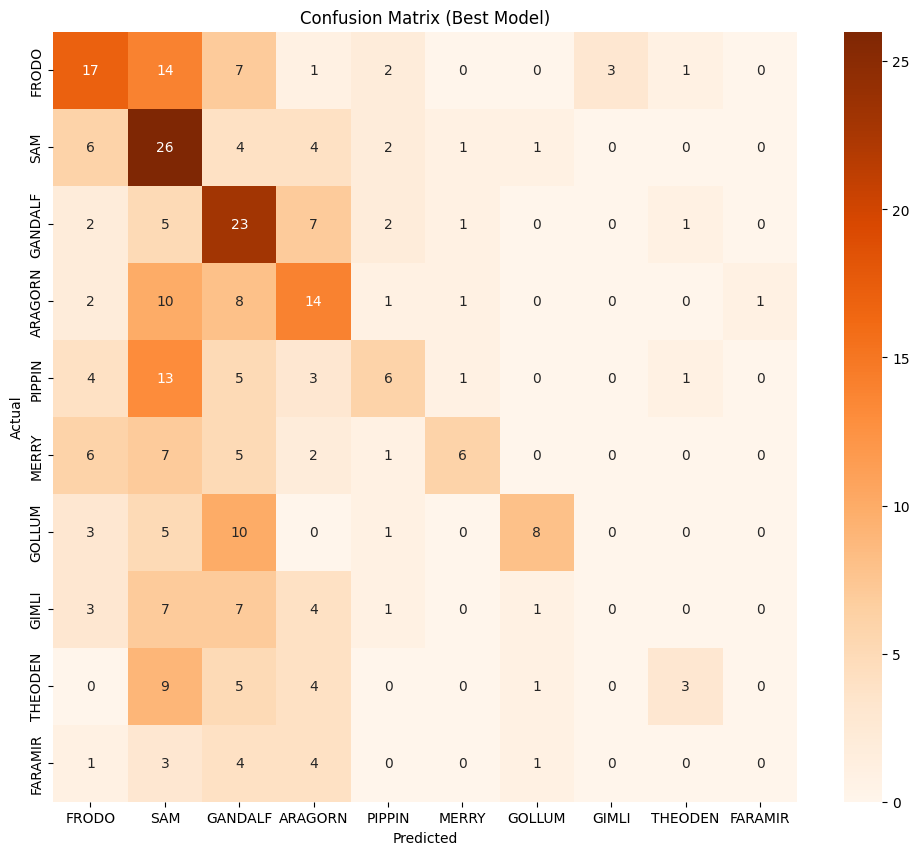

In [ ]:
# Confusion matrix
cm_best = confusion_matrix(y_test_filt, y_pred_best, labels=top_characters)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_best, annot=True, fmt='d', xticklabels=top_characters, yticklabels=top_characters, cmap='Oranges')
plt.title("Confusion Matrix (Best Model)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


The final confusion matrix shows a more focused pattern of correct predictions after hyperparameter tuning, with stronger diagonal clusters for characters like FRODO, SAM, and GANDALF, reflecting the improved accuracy. Misclassifications still occur but have been reduced compared to earlier iterations, especially for key characters. For example, FRODO is now correctly predicted 17 times, and SAM has 26 correct predictions. However, some confusions still exist, such as PIPPIN and MERRY being mistaken for each other, likely due to their overlapping contexts in the dataset. This matrix highlights that while tuning has improved performance, further refinements are needed to resolve remaining ambiguities between similar characters.

# ***5 Conclusions and Summary***

This project explored The Lord of the Rings scripts using Natural Language Processing (NLP) and machine learning techniques. The aim was to analyze the language structure, dialogue distribution, and thematic elements across the trilogy while attempting to classify characters based on their dialogue. By leveraging multiple NLP methods, we gained valuable insights into the linguistic patterns of the characters and how dialogue distribution affected our models' performances.

## ***5.1 Key Findings***
* **Dialogue Analysis:** Central characters like Frodo, Sam, and Gandalf had the most lines, with Gandalf delivering the longest dialogues. Action-oriented characters like Pippin and Merry had shorter lines.
* **Word Frequencies:** Frequent words like "come" and "yes" reflect the themes of urgency and decision-making, while character-specific vocabularies aligned with their roles in the narrative.
* **Clustering**: KMeans clustering showed some success in identifying dialogue patterns, but overlap in contexts made clear separation difficult.
* **Character Classification:** The initial Random Forest model had low accuracy (19.36%) due to class imbalance. After focusing on the top 10 characters and tuning the model, accuracy improved to 33.01%, with better performance for central characters like Frodo, Sam, and Gandalf.

## **5.2 Challenges and Limitations**
* **Class Imbalance:** Characters with fewer lines, like Gimli and Faramir, had poor recall, affecting overall model performance.
* **Context Overlap:** Characters with similar speech styles, like Pippin and Merry, were often misclassified.
* **Feature Representation:** TF-IDF and SVD, while useful, may not fully capture subtle differences in character speech.

This project showed how NLP can be used to analyze dialogue structure in The Lord of the Rings. While the classification models faced challenges, the analysis provided valuable insights into the characters' language. Future improvements could lead to more accurate models and deeper understanding of the dialogue.